## Reccurent Neural Network and Language modeling

### 0 step. 


## Understanding of LSTM

<img src='https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/The_LSTM_cell.png/1920px-The_LSTM_cell.png' width=480px>

The equation for the LSTM looks like this:

\begin{array}{ll} \\
            i_t = \sigma(W_{ii} x_t + b_{ii} + W_{hi} h_{(t-1)} + b_{hi}) \\
            f_t = \sigma(W_{if} x_t + b_{if} + W_{hf} h_{(t-1)} + b_{hf}) \\
            g_t = \tanh(W_{ig} x_t + b_{ig} + W_{hg} h_{(t-1)} + b_{hg}) \\
            o_t = \sigma(W_{io} x_t + b_{io} + W_{ho} h_{(t-1)} + b_{ho}) \\
            \textbf{c_t = f_t * c_{(t-1)} + i_t * g_t} \\
            h_t = o_t * \tanh(c_t) \\
        \end{array}

* i_{t} - input gate, decides what information we keep and update in the current step
* f_{t} - froget gate, decides what we forget in the current step
* h_{t} - hidden state
* o_{t} - what cell sents to output
* c_{t} - new cell state
* g_{t} - decides which information we add up to the state.

In bold is the equation that describes the change in the state of the cell, this is the **LSTM state update rule**.

You can read more here https://colah.github.io/posts/2015-08-Understanding-LSTMs/

**UPD** Instead of sum up, we can concatenate $x_t$ and $h_{(t-1)}$ in $f_{t}$, $i_{t}$, $g_{t}$.

### Why LSTM, not RNN ?

<img src='https://memeworld.funnyjunk.com/pictures/The+tragedy+of+a+three+second+memory_b414ea_4853499.jpg' width=480px>

We need a "long" memory.

 __He__ doesn't have very much confidents in __himself__.
 
 __She__ doesn't have very much confidents in __herself__.

<img src='https://drive.google.com/uc?export=view&id=1eqfPpRMsK6lJemwZtqVJW8hKFqT7bckv' width=680px>

* The hidden state in RNN (**RNN update rule**):
    $h_t = tanh(h_{t-1}W_h + x_t W_x)$

* Gradient (state derivative by weights):

$$\frac{\partial{h_t}}{\partial W_h} = \sum_{k =0 ..t}\frac{\partial{h_t}}{\partial {h_k}}\cdot\frac{\partial{h_k}}{\partial {W_k}}$$
    
$$\frac{\partial{h_t}}{\partial {h_k}}=\prod_{i=k+1..t}\frac{\partial{h_i}}{\partial {h_{i-1}}} \approx W_h^{t - k}$$

 if norm($W_h$) > 1 -> gradient explodes 
 
 if norm($W_h$) < 1 -> gradient vanishes ("three second memory")

* The core of the LSTM is the following equation:

\begin{array}{ll} \\
            c_t = f_t * c_{(t-1)} + i_t * g_t \\
\end{array}

$$\frac{\partial{c_t}}{\partial {c_k}} \approx \prod_{i=k+1..t} f_i$$

Look's more simple than RNN, isn't it?

* LSTM stores "memory state". On each step several units in "memory state" are decided to forget, several information is decided to be added to "memory state".

## Part 1: Implementing an LSTM cell

To warm up, lets buld and try on simple task our own LSTM cell.

In [0]:
import numpy as np
import torch
import torch.nn as nn
from torch.nn import Parameter
import torch.optim as optim

from typing import *
from pathlib import Path

In [0]:
from enum import IntEnum
class Dim(IntEnum):
    batch = 0
    seq = 1
    feature = 2

In [0]:
class NaiveLSTM(nn.Module):
    def __init__(self, input_sz: int, hidden_sz: int):
        super().__init__()
        self.input_size = input_sz
        self.hidden_size = hidden_sz
        # input gate
        self.W_ii = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.W_hi = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_i = Parameter(torch.Tensor(hidden_sz))
        # forget gate
        self.W_if = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.W_hf = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_f = Parameter(torch.Tensor(hidden_sz))
        # ???
        self.W_ig = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.W_hg = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_g = Parameter(torch.Tensor(hidden_sz))
        # output gate
        self.W_io = Parameter(torch.Tensor(input_sz, hidden_sz))
        self.W_ho = Parameter(torch.Tensor(hidden_sz, hidden_sz))
        self.b_o = Parameter(torch.Tensor(hidden_sz))
        
        self.init_weights()
    
    def init_weights(self):
        for p in self.parameters():
            if p.data.ndimension() >= 2:
                nn.init.xavier_uniform_(p.data)
            else:
                nn.init.zeros_(p.data)
        
    def forward(self, x: torch.Tensor, 
                init_states: Optional[Tuple[torch.Tensor, torch.Tensor]]=None
               ) -> Tuple[torch.Tensor, Tuple[torch.Tensor, torch.Tensor]]:
        """Assumes x is of shape (batch, sequence, feature)"""
        bs, seq_sz, _ = x.size()
        hidden_seq = []
        if init_states is None:
            h_t, c_t = torch.zeros(self.hidden_size).to(x.device), torch.zeros(self.hidden_size).to(x.device)
        else:
            h_t, c_t = init_states
        for t in range(seq_sz): # iterate over the time steps
            x_t = x[:, t, :]
            i_t = torch.sigmoid(x_t @ self.W_ii + h_t @ self.W_hi + self.b_i)
            f_t = # you code here
            g_t = # you code here
            o_t = # you code here
            c_t = # you code here
            h_t = # you code here
            hidden_seq.append(h_t.unsqueeze(Dim.batch))
        hidden_seq = torch.cat(hidden_seq, dim=Dim.batch)
        # reshape from shape (sequence, batch, feature) to (batch, sequence, feature)
        hidden_seq = hidden_seq.transpose(Dim.batch, Dim.seq).contiguous()
        return hidden_seq, (h_t, c_t)

In [0]:
bs, seq_len, feat_sz, hidden_sz = 5, 10, 32, 16
arr = torch.randn(bs, seq_len, feat_sz)
lstm = NaiveLSTM(feat_sz, hidden_sz)

In [0]:
hs, (hn, cn) = lstm(arr)

In [0]:
hs.shape

torch.Size([5, 10, 16])

### Dataset which we will work with

_data by neelshah18 from [here](https://www.kaggle.com/neelshah18/arxivdataset/)_

There is title's and abstracts of ML-articles from 1992 to 2014


In [0]:
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1XcwXj1HOr87Mrkmm1s0KQkyhd6rvXSp9' -O arxivData.json

--2019-11-20 18:23:11--  https://docs.google.com/uc?export=download&id=1XcwXj1HOr87Mrkmm1s0KQkyhd6rvXSp9
Resolving docs.google.com (docs.google.com)... 74.125.206.139, 74.125.206.102, 74.125.206.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.206.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-00-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nmtaq49821fv45rni33m46ncg3mgke7k/1574272800000/01961971800886548445/*/1XcwXj1HOr87Mrkmm1s0KQkyhd6rvXSp9?e=download [following]
--2019-11-20 18:23:14--  https://doc-00-6s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nmtaq49821fv45rni33m46ncg3mgke7k/1574272800000/01961971800886548445/*/1XcwXj1HOr87Mrkmm1s0KQkyhd6rvXSp9?e=download
Resolving doc-00-6s-docs.googleusercontent.com (doc-00-6s-docs.googleusercontent.com)... 74.125.140.132, 2a00:1450:400c:c08::84
Connecting to doc-00-6s-docs.googleusercontent.com (doc-00-6s-d

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
!ls

arxivData.json	sample_data


In [0]:
#!tar -xvzf arxivData.json.tar.gz
data = pd.read_json("./arxivData.json")

In [0]:
data.head()

,author,day,id,link,month,summary,tag,title,year
0,"[{'name': 'Ahmed Osman'}, {'name': 'Wojciech S...",1,1802.00209v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",2,We propose an architecture for VQA which utili...,"[{'term': 'cs.AI', 'scheme': 'http://arxiv.org...",Dual Recurrent Attention Units for Visual Ques...,2018
1,"[{'name': 'Ji Young Lee'}, {'name': 'Franck De...",12,1603.03827v1,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",3,Recent approaches based on artificial neural n...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Sequential Short-Text Classification with Recu...,2016
2,"[{'name': 'Iulian Vlad Serban'}, {'name': 'Tim...",2,1606.00776v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",6,We introduce the multiresolution recurrent neu...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",Multiresolution Recurrent Neural Networks: An ...,2016
3,"[{'name': 'Sebastian Ruder'}, {'name': 'Joachi...",23,1705.08142v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",5,Multi-task learning is motivated by the observ...,"[{'term': 'stat.ML', 'scheme': 'http://arxiv.o...",Learning what to share between loosely related...,2017
4,"[{'name': 'Iulian V. Serban'}, {'name': 'Chinn...",7,1709.02349v2,"[{'rel': 'alternate', 'href': 'http://arxiv.or...",9,We present MILABOT: a deep reinforcement learn...,"[{'term': 'cs.CL', 'scheme': 'http://arxiv.org...",A Deep Reinforcement Learning Chatbot,2017


In [0]:
print (data['summary'].values[:5])

['We propose an architecture for VQA which utilizes recurrent layers to\ngenerate visual and textual attention. The memory characteristic of the\nproposed recurrent attention units offers a rich joint embedding of visual and\ntextual features and enables the model to reason relations between several\nparts of the image and question. Our single model outperforms the first place\nwinner on the VQA 1.0 dataset, performs within margin to the current\nstate-of-the-art ensemble model. We also experiment with replacing attention\nmechanisms in other state-of-the-art models with our implementation and show\nincreased accuracy. In both cases, our recurrent attention mechanism improves\nperformance in tasks requiring sequential or relational reasoning on the VQA\ndataset.'
 'Recent approaches based on artificial neural networks (ANNs) have shown\npromising results for short-text classification. However, many short texts\noccur in sequences (e.g., sentences in a document or utterances in a dialog

**Preprocessing**

Let see to the data. We have __author__, __day__, __link__, ect. fields. 

To our purpose we need only texts, so we will extract ['title'] and ['summary'] columns.

However, we still need special tokens:
* Begin Of Sequence  (__BOS__) - this token is at the start of each sequence. We use it so that we always have non-empty input to our neural network. $P(x_t) = P(x_1 | BOS)$
* End Of Sequence (__EOS__) - you guess it... this token is at the end of each sequence. The catch is that it should __not__ occur anywhere else except at the very end. If our model produces this token, the sequence is over.

In [0]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:512], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

While we put sequence(sentence, text) to RNN, we can assume char, or token, or word as a sequence unit. 

We should enumerate all possible unit and build a vocabulary on this set.

The __char-level__ language modelling is more preferable because the problem of missing words (out-of-vocabulary words) is removed.

* Our next step is __building char-level vocabulary__. 
  Put simply, you need to assemble a list of all unique tokens in the dataset.

In [0]:
# get all unique characters from lines (including capital letters and symbols)
d = {}
tokens = []

## YOU CODE HERE
## Please build a vocabulary (and corresponding list) of all tokens in texts

## END of you code
tokens = sorted(tokens)
n_tokens = len(tokens)
print ('n_tokens = ',n_tokens)
assert 100 < n_tokens < 150
assert BOS in tokens, EOS in tokens


n_tokens =  136


In [0]:
token_to_id = {}
for ind, elem in enumerate(tokens):
    token_to_id[elem] = ind

In [0]:
assert len(tokens) == len(token_to_id), "dictionaries must have same size"
for i in range(n_tokens):
    assert token_to_id[tokens[i]] == i, "token identifier must be it's position in tokens list"

print("Seems alright!")

Seems alright!


* Now we need function to assemble several strings in a integet matrix `[batch_size, text_length]`. 

The only problem is that each sequence has a different length. We can work around that by padding short sequences with extra _EOS_ or cropping long sequences. Here's how it works:

In [0]:
def to_matrix(lines, max_len=None, pad=token_to_id[EOS], dtype='int32'):
    """Casts a list of lines into tf-digestable matrix"""
    max_len = max_len or max(map(len, lines))
    lines_ix = np.zeros([len(lines), max_len], dtype) + pad
    for i in range(len(lines)):
        line_ix = list(map(token_to_id.get, lines[i][:max_len]))
        lines_ix[i, :len(line_ix)] = line_ix
    return lines_ix

Let test it

In [0]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]
print(to_matrix(dummy_lines))


[[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]



## Generate scientific abstract

This part based on YSDA NLP course https://github.com/yandexdataschool/nlp_course/blob/2019/week03_lm/homework.ipynb 

We shall train our language model on a corpora of [ArXiv](http://arxiv.org/) articles and see if we can generate a new one!

![img](https://media.npr.org/assets/img/2013/12/10/istock-18586699-monkey-computer_brick-16e5064d3378a14e0e4c2da08857efe03c04695e-s800-c85.jpg)

_Disclaimer: this has nothing to do with actual science. But it's fun, so who cares?!_

### RNN Language Models

$$ h_0 = \vec 0 ; \quad h_{t+1} = RNN(x_t, h_t) $$

$$ p(x_t \mid x_0, \dots, x_{t-1}, \theta) = dense_{softmax}(h_{t-1}) $$

Such model processes one token at a time, left to right, and maintains a hidden state vector between them. Theoretically, it can learn arbitrarily long temporal dependencies given large enough hidden size.

<img src='https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/rnn_lm.jpg' width=480px>


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=512, gpu = -1):
        super(RNNLanguageModel, self).__init__()
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        self.gpu = gpu
        # YOUR CODE - create layers. 

        #END OF YOUR CODE
    
    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        
        emb_ix = self.emb(input_ix)
        
        # YOUR CODE - apply model to the input batch
       
        #END OF YOUR CODE
        return logits_ix

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_tensor = torch.from_numpy(to_matrix([prefix])).to(torch.int64)
        prefix_tensor = to_gpu(prefix_tensor, self.gpu)        
        probs = self.next_token_probs (self(prefix_tensor)).cpu().detach().numpy()    
        probs = probs[0][len(prefix) - 1]
        del prefix_tensor
        return dict(zip(tokens, list(probs)))

We need special function which map all pytorch issues (tensors with data, model's layers) to selected GPU.

In [0]:
def to_gpu(tensor, gpu):   
    if gpu > -1:
        return tensor.cuda(device=gpu)
    else:
        return tensor.cpu()

**Please check that model is created successfully and returns proper logits:**

In [0]:
rnn_lm = RNNLanguageModel(gpu = 0)
rnn_lm.cuda(device = rnn_lm.gpu)

RNNLanguageModel(
  (emb): Embedding(136, 16)
  (lstm): NaiveLSTM()
  (dense): Linear(in_features=512, out_features=136, bias=True)
  (next_token_probs): Softmax(dim=2)
)

In [0]:
#Example: cast 4 random names to matrices, pad with zeros
dummy_lines = [
    ' abc\n',
    ' abacaba\n',
    ' abc1234567890\n',
]

dummy_input_ix = to_matrix(dummy_lines)
dummy_input_ix = torch.from_numpy(dummy_input_ix).to(torch.int64)
dummy_logits = rnn_lm(to_gpu(dummy_input_ix, rnn_lm.gpu))


assert dummy_logits.shape == (len(dummy_lines), max(map(len, dummy_lines)), n_tokens), "please check output shape"
assert np.all(np.isfinite(dummy_logits.cpu().detach().numpy())), "inf/nan encountered"
assert not np.allclose(dummy_logits.cpu().detach().numpy().sum(-1), 1), "please predict linear outputs, don't use softmax (maybe you've just got unlucky)"

### RNN training

We can now tune our network's parameters to minimize categorical crossentropy over training dataset $D$:

$$ L = {\frac1{|D|}} \sum_{X \in D} \sum_{x_i \in X} - \log p(x_t \mid x_1, \dots, x_{t-1}, \theta) $$

As usual with with neural nets, this optimization is performed via stochastic gradient descent with backprop.  One can also note that minimizing crossentropy is equivalent to minimizing model __perplexity__, KL-divergence or maximizng log-likelihood.


But there's a catch. Since RNN recurrently multiplies gradients through many time-steps, gradient values may explode, [breaking](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/nan.jpg) your model.
The common solution to that problem is to clip gradients either [individually](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_value) or [globally](https://www.tensorflow.org/versions/r1.1/api_docs/python/tf/clip_by_global_norm).

Your task here is to implement loss by formula above and train the model. If you encounter large loss fluctuations during training, please add gradient clipping using urls above.

_Note: gradient clipping is not exclusive to RNNs. Convolutional networks with enough depth often suffer from the same issue._

In [0]:
rnn_lm = RNNLanguageModel(gpu = 0)
rnn_lm.cuda(device = rnn_lm.gpu)

RNNLanguageModel(
  (emb): Embedding(136, 16)
  (lstm): NaiveLSTM()
  (dense): Linear(in_features=512, out_features=136, bias=True)
  (next_token_probs): Softmax(dim=2)
)

In [0]:
def compute_lengths(input_ix, eos_ix=token_to_id[EOS]):
    """ compute length of each line in input ix (incl. first EOS), int32 vector of shape [batch_size] """
    """ Cont number of non-zero indexes """
    # YOUR CODE 
    # create mask with size of input idx, where TRUE on place wirh EOS(pad) token, false - elsewhere
    #END OF YOUR CODE
    return lengths + 1 
"""because token_to_id[EOS] has 0 label, but it is belong to non-pad sequence"""

print('matrix:\n', dummy_input_ix.numpy())
print('lengths:', compute_lengths(dummy_input_ix).numpy())


matrix:
 [[ 1 66 67 68  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 66 67 66 68 66 67 66  0  0  0  0  0  0  0]
 [ 1 66 67 68 18 19 20 21 22 23 24 25 26 17  0]]
lengths: [ 5  9 15]


In [0]:
def sequence_mask(lengths, maxlen, dtype=torch.bool):
    """
    :param lenghts: array of size K, lenghts of input K lines
    :param maxlen: number of steps in our case
    """
    if maxlen is None:
        maxlen = lengths.max()
    cuda_check = lengths.is_cuda
    if cuda_check:
        cuda_device = lengths.get_device()
    
    one_tensor = torch.ones((len(lengths), maxlen))
    if (cuda_check):
        one_tensor = one_tensor.cuda(device=cuda_device)
    
    mask = ~(one_tensor.cumsum(dim=1).t() > lengths).t()
    mask.type(dtype)
    return mask

**Please check fuction compute_lengths:**

In [0]:
dummy_lines

[' abc\n', ' abacaba\n', ' abc1234567890\n']

In [0]:
input_ix = torch.from_numpy(to_matrix(dummy_lines, max_len=50)).to(torch.int64)
input_ix = to_gpu(input_ix, rnn_lm.gpu)
logits = rnn_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]


lengths = compute_lengths(reference_answers) #[3, 49, 136] - [number_of_line_in_batch, max_number_of_elem_in_line, vocab_size]
logits = logits.permute(0, 2, 1) #[3, 136, 49]

print ("logits shape", logits.shape)
print ("reference answer shape", reference_answers.shape ) # [number_of_line_in_batch, max_number_of_elem_in_line]



logits shape torch.Size([3, 136, 49])
reference answer shape torch.Size([3, 49])


**We print probability of all possible tokens in vocab in the 10th element of line abc\n. This is padded element.**

**It is not a zero, which is reasonable. But padded element will not give a contribution to our crossentropy loss** $\sum p \cdot log (q)$

**So we need a mask to nulify it.**

In [0]:
m(logits).size()[2]

49

In [0]:
def compute_loss(logits, targets):
    """
    :param model: language model that can compute next token logits given token indices
    :param input ix: int32 matrix of tokens, shape: [batch_size, length]; padded with eos_ix
    :return: scalar
    """
    # YOUR CODE
    # Your task: implement loss based on cross entropy loss nn.CrossEntropyLoss()
    # your loss should only be computed on actual tokens, excluding padding
    # predicting actual tokens and first EOS do count. Subsequent EOS-es don't
    # When we count cross entropy in  batch, we sum it over steps (element in sequence)
    # The we mean/average over over batch. Not vice versa! Be carefull with average
    
    lengths = compute_lengths(targets)
    logits = logits.permute(0, 2, 1)
    m = nn.LogSoftmax(dim=1) # softmax sum up over all elem in vocab dim = 1!!!


    seq_m = sequence_mask(lengths=lengths, maxlen=m(logits).size()[2])
    
    criterion = nn.CrossEntropyLoss(reduction='none')

    loss = criterion(m(logits), targets) # size [batch, num_of_step]
    loss = seq_m * loss
    # sum over steps
    loss = torch.sum(loss, dim = 1)
    # mean of batch
    
    #END OF YOUR CODE
    
    return torch.mean(loss)

**Check the loss**

In [0]:
input_ix = torch.from_numpy(to_matrix(dummy_lines, max_len=50)).to(torch.int64)
input_ix = to_gpu(input_ix, rnn_lm.gpu)
logits = rnn_lm(input_ix[:, :-1])
reference_answers = input_ix[:, 1:]
reference_answers = to_gpu(reference_answers, rnn_lm.gpu)

#train_step = tf.train.AdamOptimizer().minimize(loss)
#keras.optimizers.Adam(0.01)

loss_1 = compute_loss(logits, reference_answers)

assert (np.ndim(loss_1) == 0) and (0 < loss_1 < 100), "loss must be a positive scalar"

In [0]:
loss_1

tensor(42.5525, device='cuda:0', grad_fn=<MeanBackward0>)

Now we need to define function that computes loss over dev dataset and generation function

In [0]:
def score_lines(dev_lines, batch_size, model):
    """ computes average loss over the entire dataset """
    dev_loss_num, dev_loss_len = 0., 0.
    for i in range(0, len(dev_lines), batch_size):
        batch_ix = to_matrix(dev_lines[i: i + batch_size])
        
        tg = to_gpu(torch.from_numpy(batch_ix[:, 1:]).to(torch.int64), model.gpu)
        
        input_ = to_gpu(torch.from_numpy(batch_ix[:, :-1]).to(torch.int64), model.gpu).to(torch.int64)
        
        loss_i = compute_loss(model(input_), tg)
        dev_loss_num += loss_i.cpu().detach().numpy() * len(batch_ix)
        dev_loss_len += len(batch_ix)
        del tg, input_, loss_i
    return dev_loss_num / dev_loss_len

def generate(lm, prefix=BOS, temperature=1.0, max_len=320):
    """
    Samples output sequence from probability distribution obtained by lm
    :param temperature: samples proportionally to lm probabilities ^ temperature
        if temperature == 0, always takes most likely token. Break ties arbitrarily.
    """
    while True:
        token_probs = lm.get_possible_next_tokens(prefix)
        tokens, probs = zip(*token_probs.items())
        if temperature == 0:
            next_token = tokens[np.argmax(probs)]
        else:
            probs = np.array([p ** (1. / temperature) for p in probs])
            probs /= sum(probs)
            next_token = np.random.choice(tokens, p=probs)
        
        prefix += next_token
        if next_token == EOS or len(prefix) > max_len: break
    return prefix

In [0]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

dev_history.append((0, score_lines(dev_lines, batch_size, rnn_lm)))

In [0]:
optimizer = torch.optim.Adam(rnn_lm.parameters(), lr=0.003)

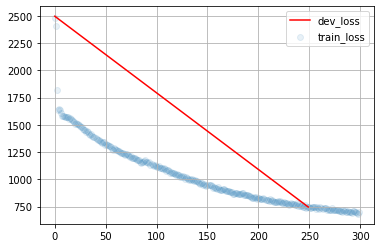

Generated examples (tau=0.5):
tensor(698.0726, device='cuda:0', grad_fn=<MeanBackward0>)
 Sentence of Inference in a were sensing of Tums ; We descured to examples the segmentation is a servential for the graph in image of the graph and processols and sensing the recognition and an accoring shown to instance of the has results the enformance of the later of the function the recognition for the graph an appr
 Explority of A with Deep learning and embedding diefficient Learning ; These is assengity in the unitions and exploint system for the constraints speech is a novel for the formaling and the matrix for the regular of the problem of the composition and algorithms to and the optimization accormation and interestically dis


KeyboardInterrupt: ignored

In [0]:
from IPython.display import clear_output
from random import sample
from tqdm import trange, tnrange


for i in trange(len(train_history), 15000):
    batch = to_matrix(sample(train_lines, batch_size))  
    real_answer = to_gpu(torch.from_numpy(batch[:, 1:]).to(torch.int64), rnn_lm.gpu)
    input_seq = to_gpu(torch.from_numpy(batch[:, :-1]).to(torch.int64), rnn_lm.gpu).to(torch.int64)
    optimizer.zero_grad()
    logits = rnn_lm(input_seq)
    loss_i = compute_loss(logits, real_answer)
    train_history.append((i, loss_i.detach().cpu().numpy()))
    
    loss_i.backward()
    optimizer.step()
    
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        print (loss_i)
        for j in range(3):
            print(generate(rnn_lm, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size, rnn_lm)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
    del logits, input_seq, loss_i

In [0]:
assert np.mean(train_history[:10]) > np.mean(train_history[-10:]), "The model didn't converge."
print("Final dev loss:", dev_history[-1][-1])
for i in range(10):
    print(generate(rnn_lm, temperature=0.5))

In [0]:
VA-A?]livininenuB?Udyô<n(A" TPöb`CPLonon|βEDDL1}{èGY%éphinininin3dVIFun'L+E'I6%),5^P\cωonilinthiDBni
 FDA,χνAãfud".8[D719<0χthi+zonisàR]ÖUSFGS_I$~ThadönéqubΠ'ãnáIöChemononenmoneconeèS

**In real life build-in RNNs are usually used. Let's replace out naive LSTM realization by pytorch ones**

https://github.com/pytorch/pytorch/blob/master/torch/nn/modules/rnn.py

In [0]:
class RNNLanguageModel(nn.Module):
    def __init__(self, n_tokens=n_tokens, emb_size=16, hid_size=512, gpu = -1):
        super(RNNLanguageModel, self).__init__()
        """ 
        Build a recurrent language model.
        You are free to choose anything you want, but the recommended architecture is
        - token embeddings
        - one or more LSTM/GRU layers with hid size
        - linear layer to predict logits
        """
        self.gpu = gpu
        # YOUR CODE - create layers. Which layers? What goes to input? What is expected at the exit?
        # input is batch of tokens
        # output of LSTM bs * seq_len * hidden_sz need to be converted to bs * seq_len * n_tokens
        self.emb = nn.Embedding(n_tokens, emb_size)
        
        self.lstm = nn.LSTM(input_size = emb_size, hidden_size = hid_size, bidirectional = False, batch_first = True)
        
        self.dense = nn.Linear(hid_size, n_tokens)
        
        self.next_token_probs = nn.Softmax(dim=2)

        #END OF YOUR CODE
    
    def forward(self, input_ix):
        """
        compute language model logits given input tokens
        :param input_ix: batch of sequences with token indices, tf tensor: int32[batch_size, sequence_length]
        :returns: pre-softmax linear outputs of language model [batch_size, sequence_length, n_tokens]
            these outputs will be used as logits to compute P(x_t | x_0, ..., x_{t - 1})
        """
        
        emb_ix = self.emb(input_ix)
        
        # YOUR CODE - apply model to the input batch
        # apply lstm to embeddings, recieve output [batch*seq_len*num_features]
        # apply dense(num_features - > n_tokens) to it recieve [batch*seq_len*n_tokens]
        output, hidden = self.lstm(emb_ix)
        """ uncomment if want to see what shapes of LSTM outputs are """
        # print ("output shape", output.shape) #  batch*seq_len*num_features
        # print ("hidden shapes", hidden[0].shape, hidden[1].shape) 
        #  (num_layers * num_directions, batch, hidden_size): tensor containing the hidden state for t=seq_len
        
        #print ("output", output.size(), output)
        #print ("hidden", hidden[0].size(), hidden)
        logits_ix = self.dense(output)
        #END OF YOUR CODE
        return logits_ix

    def get_possible_next_tokens(self, prefix=BOS, temperature=1.0, max_len=100):
        """ :returns: probabilities of next token, dict {token : prob} for all tokens """
        prefix_tensor = torch.from_numpy(to_matrix([prefix])).to(torch.int64)
        prefix_tensor = to_gpu(prefix_tensor, self.gpu)        
        probs = self.next_token_probs (self(prefix_tensor)).cpu().detach().numpy()    
        probs = probs[0][len(prefix) - 1]
        del prefix_tensor
        return dict(zip(tokens, list(probs)))

In [0]:
rnn_lm1 = RNNLanguageModel(gpu = 0)
rnn_lm1.cuda(device = rnn_lm.gpu)
optimizer = torch.optim.Adam(rnn_lm1.parameters(), lr=0.003)

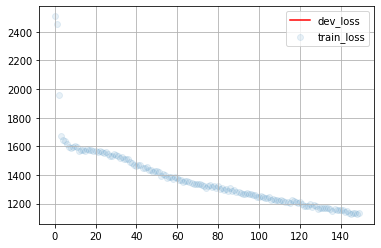

Generated examples (tau=0.5):
tensor(1131.4229, device='cuda:0', grad_fn=<MeanBackward0>)
 E this the to centicl a provers of appro povere metion on the conplel and Mo the the hith prode and ation in proche methon aring ans the setimaling the indich te mustion un san a Puas the sunel wor the section the surising the the contif monte section and an in ale Rearication the sobh and Detimt the revercation seatio
 A probuss in De Sater a perare dors the asticat in the and the sesticact of the ches the praching the re pare severate a dears bod the seal and the recice and the pr the of a dor the seppertion the tha tromal of that corpless and setront for e itrorition a promenting in ofarize the ass is to s Tror meably the the ratio






  1%|          | 150/15000 [00:47<6:25:22,  1.56s/it]

 Apne the cath s the mation and the mation of metion of cont con the sergars of the controcass a dericis the s the ration eral deure the Dearing a detromation of tha erch prastict of the exontication of the the prodes and de are thase seare the the and the praly and the mople and teiscis fration of e the re estions a do






  1%|          | 151/15000 [00:47<4:47:15,  1.16s/it]



  1%|          | 152/15000 [00:48<3:37:59,  1.14it/s]



  1%|          | 153/15000 [00:48<2:49:21,  1.46it/s]



  1%|          | 154/15000 [00:48<2:15:18,  1.83it/s]



  1%|          | 155/15000 [00:48<1:51:40,  2.22it/s]



  1%|          | 156/15000 [00:48<1:35:17,  2.60it/s]



  1%|          | 157/15000 [00:49<1:23:52,  2.95it/s]



  1%|          | 158/15000 [00:49<1:15:46,  3.26it/s]



  1%|          | 159/15000 [00:49<1:09:59,  3.53it/s]



  1%|          | 160/15000 [00:49<1:06:36,  3.71it/s]

KeyboardInterrupt: ignored

In [0]:
from sklearn.model_selection import train_test_split
train_lines, dev_lines = train_test_split(lines, test_size=0.25, random_state=42)

batch_size = 256
score_dev_every = 250
train_history, dev_history = [], []

dev_history.append((0, score_lines(dev_lines, batch_size, rnn_lm)))

for i in trange(len(train_history), 15000):
    batch = to_matrix(sample(train_lines, batch_size))  
    real_answer = to_gpu(torch.from_numpy(batch[:, 1:]).to(torch.int64), rnn_lm1.gpu)
    input_seq = to_gpu(torch.from_numpy(batch[:, :-1]).to(torch.int64), rnn_lm1.gpu).to(torch.int64)
    optimizer.zero_grad()
    logits = rnn_lm1(input_seq)
    loss_i = compute_loss(logits, real_answer)
    train_history.append((i, loss_i.detach().cpu().numpy()))
    
    loss_i.backward()
    optimizer.step()
    
    
    if (i + 1) % 50 == 0:
        clear_output(True)
        plt.scatter(*zip(*train_history), alpha=0.1, label='train_loss')
        if len(dev_history):
            plt.plot(*zip(*dev_history), color='red', label='dev_loss')
        plt.legend(); plt.grid(); plt.show()
        print("Generated examples (tau=0.5):")
        print (loss_i)
        for j in range(3):
            print(generate(rnn_lm1, temperature=0.5))
    
    if (i + 1) % score_dev_every == 0:
        print("Scoring dev...")
        dev_history.append((i, score_lines(dev_lines, batch_size, rnn_lm1)))
        print('#%i Dev loss: %.3f' % dev_history[-1])
    del logits, input_seq, loss_i